In [1]:
import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from Initialization import initialize_Ising
import loop_opt as tnr
import cft

Ising_Tc = 2./np.log(1.+np.sqrt(2))

In [2]:
def collect_Ising(T, d_cut, size):
    keep_num_scaling = d_cut ** 2
    error_limit = 1.0E-14
    maxloop = 80
    area = 4.

    cft_result = np.zeros((size, keep_num_scaling))
    norm_list = []

    tA = initialize_Ising(T)
    tB = np.copy(tA)

    tA, tB, norm = tnr.normalize_tensor(tA, tB)
    norm_list.append(norm)
    ln_z = np.log(norm)/area

    for i in tqdm(range(size)):
        tA, tB, norm = tnr.TNR_step(tA,tB,d_cut,error_limit,maxloop)
        area *= 2
        ln_z += np.log(norm) / area
        norm_list.append(norm)
        data = cft.cal_sdimension(tA, tB, norm)
        cft_result[i, 0:min(keep_num_scaling, np.shape(data)[0])] = data[0:min(keep_num_scaling, np.shape(data)[0])]
    np.save("tnr_data/Critical_{}.npy".format(d_cut), cft_result)
    np.save("tnr_data/norm_{}.npy".format(d_cut), norm_list)

In [17]:
#This may take some time if you calculating on your laptop!
# for D in [4,8,12,16,20,24]:
#     collect_Ising(Ising_Tc, D, 30)

In [4]:
data=[]
norm_list=[]
D_list=np.array([4,8,12,16,20])
for D in D_list:
    data.append(np.real(np.load("tnr_data/Critical_{}.npy".format(D),allow_pickle=True)))
    norm_list.append(np.real(np.load("tnr_data/norm_{}.npy".format(D),allow_pickle=True))) 
cstart=2

In [5]:
lnz=np.zeros((len(D_list), len(norm_list[0])))
for i in range(len(D_list)):
    #T
    temp=0
    area=4
    #N
    for j in range(len(norm_list[0])):
        temp+=np.log(np.real(norm_list[i][j]))/area
        lnz[i,j]=temp
        area*=2
lnZ=np.zeros((len(D_list),len(norm_list[0])))
for i in range(len(norm_list[0])):
    lnZ[:,i]=lnz[:,i]*2**(i+2)

In [6]:
lnlambda0=np.zeros((len(D_list),len(data[0])))
for i in range(len(D_list)):
    for j in range(len(data[0])):
        # ln(c) = ln(Λ_0)*6/ pi　（see cft.py)
        lnlambda0[i,j]=np.pi*data[i][j][0]/6+np.log(np.real(norm_list[i][j+1]))
lE0_list=np.zeros((len(D_list),len(data[0])))
for i in range(len(D_list)):
    for j in range(len(data[0])):
        lE0_list[i,j]=-(lnlambda0[i,j]+lnZ[i,j+1])

In [7]:
def parabola_fit(x,a,b):
    return a*x**2+b
l_list=2**(np.linspace(1.5,1+0.5*len(data[0]),len(data[0])))
fd,cov=curve_fit(parabola_fit,l_list[1:8],lE0_list[-1,1:8])

## Scaling of the ground state energy
### $$E_0(L) = \epsilon_0 L - \frac{2\pi}{L}\frac{c}{6}$$

(0.0, 70000.0)

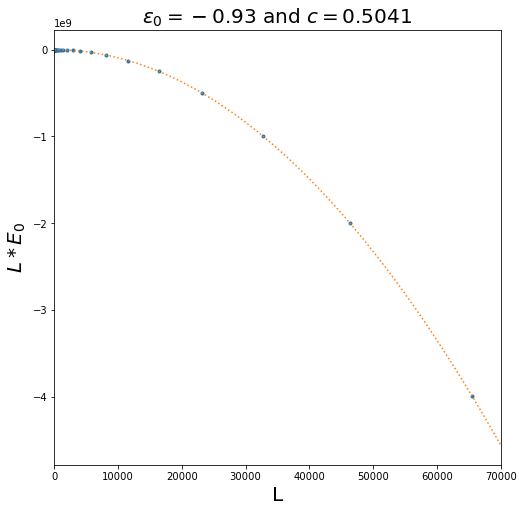

In [8]:
plt.figure(figsize=(8,8))
plt.plot(l_list,lE0_list[-1],".")
plt.plot(np.linspace(0,7e4,1000),parabola_fit(np.linspace(0,7e4,1000),fd[0],1),":",label="Fit")
plt.title(r"$\epsilon_0={0}$ and $c={1}$".format(np.round(fd[0],3),np.round(-fd[1]*6/np.pi,5)),fontsize=20)
plt.ylabel("$L*E_0$",fontsize=20)
plt.xlabel("L",fontsize=20)
plt.xlim(0,7e4)

## Finite bond-dimension effect

### Let us look at the finite-$D$ effect
 We investigate it by plotting 
### $$\delta x_\sigma = x_\sigma(L,D) - 1/8$$

In the $D\rightarrow\infty$ limit, $\delta x_\sigma$ is proportional to $1/L^2$ because the leading irrelevant operator is $T^2$ and $\bar{T}^2$. These operators have conformal spins 4, so it flip the sign every time the lattice is rotated by 45 degrees. 

**The finite bond-dimension effect, on the other hand, results in an increasing contribution to the value of $\delta x_\sigma$.**

See [my paper](https://arxiv.org/abs/2302.06632) for details. 

In [9]:
gap_list=np.zeros((len(D_list),len(data[0])))
for i in range(len(D_list)):
    gap_list[i] = data[i][:,1]
delta_sigma = gap_list - 1/8

Text(0, 0.5, '$\\delta x_\\sigma$')

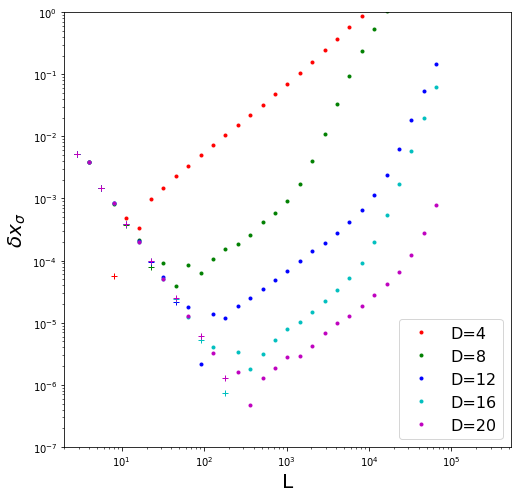

In [10]:
plt.figure(figsize=(8,8))
color_list= ["r", "g", "b", "c", "m"]
for i in range(5):
    plt.plot(l_list,(gap_list[i]-0.125),".",color=color_list[i],label="D={}".format(D_list[i]))
    plt.plot(l_list,-(gap_list[i]-0.125),"+",color=color_list[i])
plt.xscale("log")
plt.yscale("log")
plt.xlim(2,l_list[-1]*4*2)
plt.ylim(1e-7,1)
plt.legend(loc="lower right",fontsize=16)
plt.xlabel("L",fontsize=20)
plt.ylabel("$\delta x_\sigma$",fontsize=20)

In [11]:
kappa=6/(0.5*(1+np.sqrt(24)))

Text(0, 0.5, '$L^2\\delta x$')

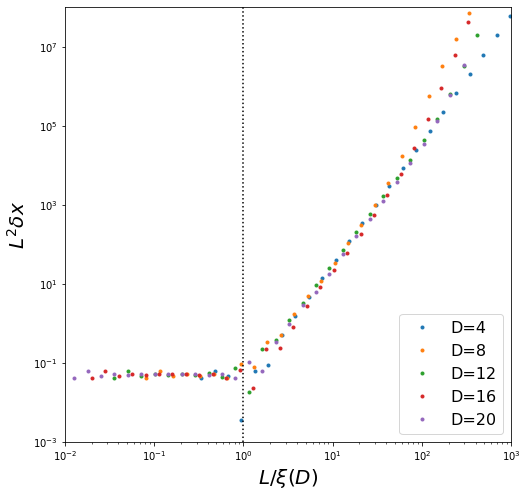

In [15]:
plt.figure(figsize=(8,8))
for i in range(5):
    plt.plot(l_list/(0.5*D_list[i]**kappa),abs(gap_list[i]-0.125)*l_list**2,".",label="D={}".format(D_list[i]))
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2,1e3)
plt.ylim(1e-3,1e8)
plt.axvline(1.,linestyle=":",color="black")
plt.legend(loc="lower right",fontsize=16)
plt.xlabel(r'$L/\xi(D)$',fontsize=20)
plt.ylabel("$L^2\delta x$",fontsize=20)

Text(0, 0.5, '$\\delta x_\\sigma$')

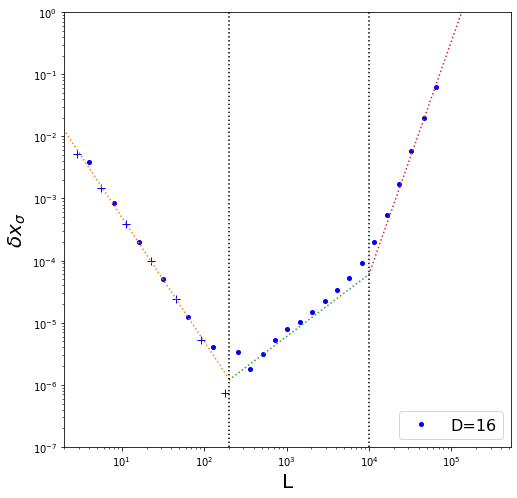

In [16]:
plt.figure(figsize=(8,8))
i=3
plt.plot(l_list,(gap_list[i]-0.125),".",markersize=8,color="blue",label="D={}".format(D_list[i]))
plt.plot(l_list,-(gap_list[i]-0.125),"+",color="blue",markersize=8)
plt.plot(np.linspace(1,200,100),5e-2*np.linspace(1,200,100)**(-2),":",color="C1")
plt.plot(np.linspace(200,1e4,100),6e-9*np.linspace(200,1e4,100),":",color="C2")
plt.plot(np.linspace(1e4,2e5,100),6e-20*np.linspace(1e4,2e5,100)**3.75,":",color="C3")
plt.axvline(200.,linestyle=":",color="black")
plt.axvline(1e4,linestyle=":",color="black")
plt.xscale("log")
plt.yscale("log")
plt.xlim(2,l_list[-1]*4*2)
plt.ylim(1e-7,1)
plt.legend(loc="lower right",fontsize=16)
plt.xlabel("L",fontsize=20)
plt.ylabel("$\delta x_\sigma$",fontsize=20)

## RG flow
Let us compute the off-critical case.

In [18]:
def collect_Ising_offcritical(T, d_cut, size):
    keep_num_scaling = d_cut ** 2
    error_limit = 1.0E-14
    maxloop = 80
    area = 4.

    cft_result = np.zeros((size, keep_num_scaling))
    norm_list = []

    tA = initialize_Ising(T)
    tB = np.copy(tA)

    tA, tB, norm = tnr.normalize_tensor(tA, tB)
    norm_list.append(norm)
    ln_z = np.log(norm)/area

    for i in tqdm(range(size)):
        tA, tB, norm = tnr.TNR_step(tA,tB,d_cut,error_limit,maxloop)
        area *= 2
        ln_z += np.log(norm) / area
        norm_list.append(norm)
        data = cft.cal_sdimension(tA, tB, norm)
        cft_result[i, 0:min(keep_num_scaling, np.shape(data)[0])] = data[0:min(keep_num_scaling, np.shape(data)[0])]
    if T > Ising_Tc:
        np.save("tnr_data/high_{}.npy".format(d_cut), cft_result)
        np.save("tnr_data/high_norm_{}.npy".format(d_cut), norm_list)
    elif T < Ising_Tc:
        np.save("tnr_data/low_{}.npy".format(d_cut), cft_result)
        np.save("tnr_data/low_norm_{}.npy".format(d_cut), norm_list)

In [ ]:
collect_Ising_offcritical(Ising_Tc*(1+1e-4),24,28)
collect_Ising_offcritical(Ising_Tc*(1-1e-4),24,28)

 25%|██████████▊                                | 7/28 [32:13<3:16:43, 562.09s/it]

In [ ]:
def initialize_Ising_mag(T,h):
    # Make initial tensor of square lattice Ising model at a temperature T
    A =np.empty((2,2,2,2))
    
    for i in range(0,2):
        si = (i - 0.5) * 2
        for j in range(0,2):
            sj = (j - 0.5) * 2
            for k in range(0,2):
                sk = (k - 0.5) * 2
                for l in range(0,2):
                    sl = (l - 0.5) * 2
                    A[i,j,k,l] = np.exp((si*sj + sj*sk + sk*sl + sl*si)/T+h/2/T*(si+sj+sk+sl))

In [ ]:
def collect_Ising_mag(h, d_cut, size):
    keep_num_scaling = d_cut ** 2
    error_limit = 1.0E-14
    maxloop = 80
    area = 4.

    cft_result = np.zeros((size, keep_num_scaling))
    norm_list = []

    tA = initialize_Ising_mag(Ising_Tc,h)
    tB = np.copy(tA)

    tA, tB, norm = tnr.normalize_tensor(tA, tB)
    norm_list.append(norm)
    ln_z = np.log(norm)/area

    for i in tqdm(range(size)):
        tA, tB, norm = tnr.TNR_step(tA,tB,d_cut,error_limit,maxloop)
        area *= 2
        ln_z += np.log(norm) / area
        norm_list.append(norm)
        data = cft.cal_sdimension(tA, tB, norm)
        cft_result[i, 0:min(keep_num_scaling, np.shape(data)[0])] = data[0:min(keep_num_scaling, np.shape(data)[0])]
    if 0 < h:
        np.save("tnr_data/mag_high_{}.npy".format(d_cut), cft_result)
        np.save("tnr_data/mag_high_norm_{}.npy".format(d_cut), norm_list)
    elif 0 > h:
        np.save("tnr_data/mag_low_{}.npy".format(d_cut), cft_result)
        np.save("tnr_data/mag_low_norm_{}.npy".format(d_cut), norm_list)

In [ ]:
collect_Ising_mag(1e-5,24,28)
collect_Ising_mag(-1e-5,24,28)